# Presence only data modelling - Generate Random Points
This notebook generates the background data points required for presence only models. For more on background points, read [this](https://rspatial.org/raster/sdm/3_sdm_absence-background.html).

## Downloads and imports

In [15]:
install.packages(c("dismo","maptools","glmnet","maxnet","raster","sp","pryr","rworldmap"))

Warning message:
“package ‘mopa’ is not available (for R version 3.6.1)”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [5]:
library(maxnet)
library(glmnet)
library(dismo)
require(maps)

Loading required package: maps


## Get data

In [3]:
train <- read.csv("../data/train_val_random.csv", header=TRUE)
test  <- read.csv("../data/test_random.csv", header=TRUE)

# Presense only train data
train_only_presence <- train[train$presence == "1", ]

In [4]:
training_data_dates <- train_only_presence["observation_date"]

Get countries from coords - https://stackoverflow.com/questions/14334970/convert-latitude-and-longitude-coordinates-to-country-name-in-r

In [5]:
library(sp)
library(rworldmap)


# The single argument to this function, points, is a data.frame in which:
#   - column 1 contains the longitude in degrees
#   - column 2 contains the latitude in degrees
coords2country = function(points)
{  
  countriesSP <- getMap(resolution='low')
    
  #setting CRS directly to that from rworldmap
  pointsSP = SpatialPoints(points, proj4string=CRS(proj4string(countriesSP)))  


  # use 'over' to get indices of the Polygons object containing each point 
  indices = over(pointsSP, countriesSP)
    
  print(unique(cbind(as.character(indices$ADMIN), as.character(indices$REGION))))

  return((indices$ADMIN))
}

### Welcome to rworldmap ###
For a short introduction type : 	 vignette('rworldmap')


#### List of countries in train data

In [7]:
train_countries = unique(coords2country(train[c("x","y")]))

      [,1]             [,2]    
 [1,] "Mauritania"     "Africa"
 [2,] "Mali"           "Africa"
 [3,] "Somaliland"     "Africa"
 [4,] "Egypt"          "Africa"
 [5,] "Morocco"        "Africa"
 [6,] "Algeria"        "Africa"
 [7,] "Sudan"          "Africa"
 [8,] "Niger"          "Africa"
 [9,] "Eritrea"        "Africa"
[10,] "Senegal"        "Africa"
[11,] "Libya"          "Africa"
[12,] "Western Sahara" "Africa"
[13,] NA               NA      
[14,] "Tunisia"        "Africa"
[15,] "Cape Verde"     "Africa"
[16,] "Chad"           "Africa"
[17,] "Ethiopia"       "Africa"
[18,] "Kenya"          "Africa"
[19,] "Somalia"        "Africa"
[20,] "Gaza"           "Europe"
[21,] "Djibouti"       "Africa"


#### List of countries in test data

In [8]:
test_countries = unique(coords2country(test[c("x","y")]))

      [,1]             [,2]    
 [1,] "Niger"          "Africa"
 [2,] "Mauritania"     "Africa"
 [3,] "Algeria"        "Africa"
 [4,] "Eritrea"        "Africa"
 [5,] "Sudan"          "Africa"
 [6,] "Egypt"          "Africa"
 [7,] "Chad"           "Africa"
 [8,] "Ethiopia"       "Africa"
 [9,] "Morocco"        "Africa"
[10,] "Western Sahara" "Africa"
[11,] "Somaliland"     "Africa"
[12,] "Mali"           "Africa"
[13,] "Libya"          "Africa"
[14,] NA               NA      
[15,] "Kenya"          "Africa"
[16,] "Somalia"        "Africa"
[17,] "Uganda"         "Africa"
[18,] "Djibouti"       "Africa"
[19,] "South Sudan"    "Africa"


#### Countries that don't match

In [10]:
identical(train_countries, test_countries)
test_countries[!(test_countries %in% train_countries)]

[1] FALSE

[1] Uganda      South Sudan
244 Levels: Afghanistan Aland Albania Algeria American Samoa Andorra ... Zimbabwe

#### Get bounding box for relevant countries

In [35]:
r <-  getData('alt' , country="Mauritania", level=0, mask=TRUE)
r1 <- getData('alt' , country="Mali", level=0, mask=TRUE)
r2 <- getData('alt' , country="Somalia", level=0, mask=TRUE)

r3 <- getData('alt' , country="Egypt", level=0, mask=TRUE)
r4 <- getData('alt' , country="Morocco", level=0, mask=TRUE)
r5 <- getData('alt' , country="Algeria", level=0, mask=TRUE)
r6 <- getData('alt' , country="Sudan", level=0, mask=TRUE)
r7 <- getData('alt' , country="Niger", level=0, mask=TRUE)
r8 <- getData('alt' , country="Eritrea", level=0, mask=TRUE)
r9 <- getData('alt' , country="Senegal", level=0, mask=TRUE)
r10 <- getData('alt' , country="Libya", level=0, mask=TRUE)
# r11 <- getData('alt' , country="Western Sahara", level=0, mask=TRUE)
r12 <- getData('alt' , country="Tunisia", level=0, mask=TRUE) # check
r13 <- getData('alt' , country="Cape Verde", level=0, mask=TRUE)
r14 <- getData('alt' , country="Chad", level=0, mask=TRUE)
r15 <- getData('alt' , country="Ethiopia", level=0, mask=TRUE)
r16<- getData('alt' , country="Djibouti", level=0, mask=TRUE)  # check
r17<- getData('alt' , country="Kenya", level=0, mask=TRUE)

# combined_raster_mali_mauri <- mosaic(r,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17, fun = min)
combined_raster <- mosaic(r,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r12,r13,r14,r15,r16,r17, fun = min,  tolerance = 0.35)
# combined_raster <- mosaic(r,r1, fun = min)

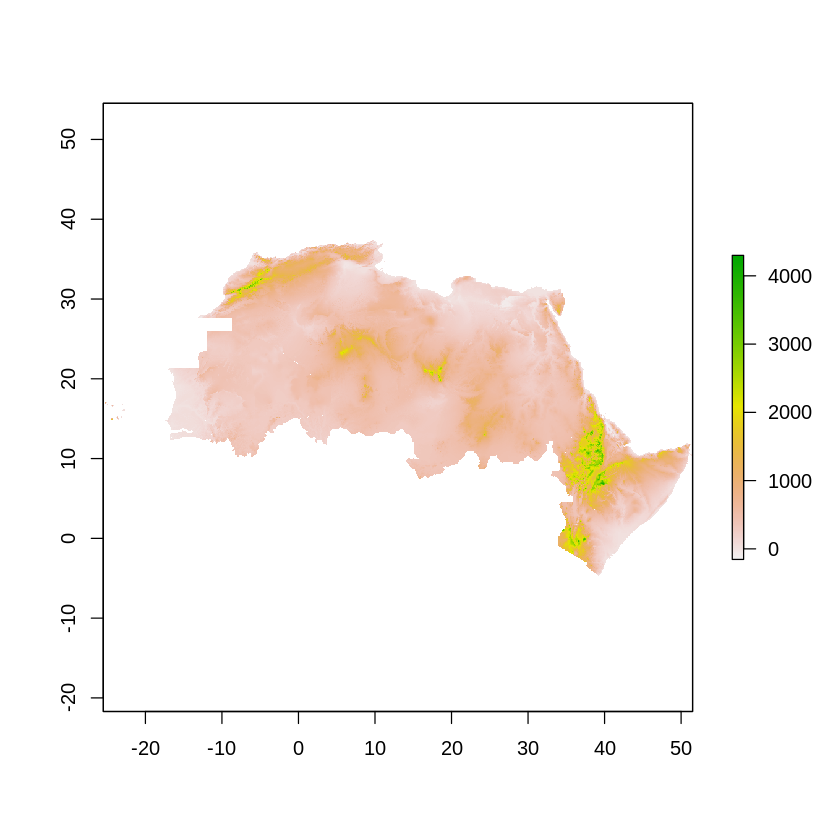

In [36]:
plot(combined_raster)

Loading required package: maps


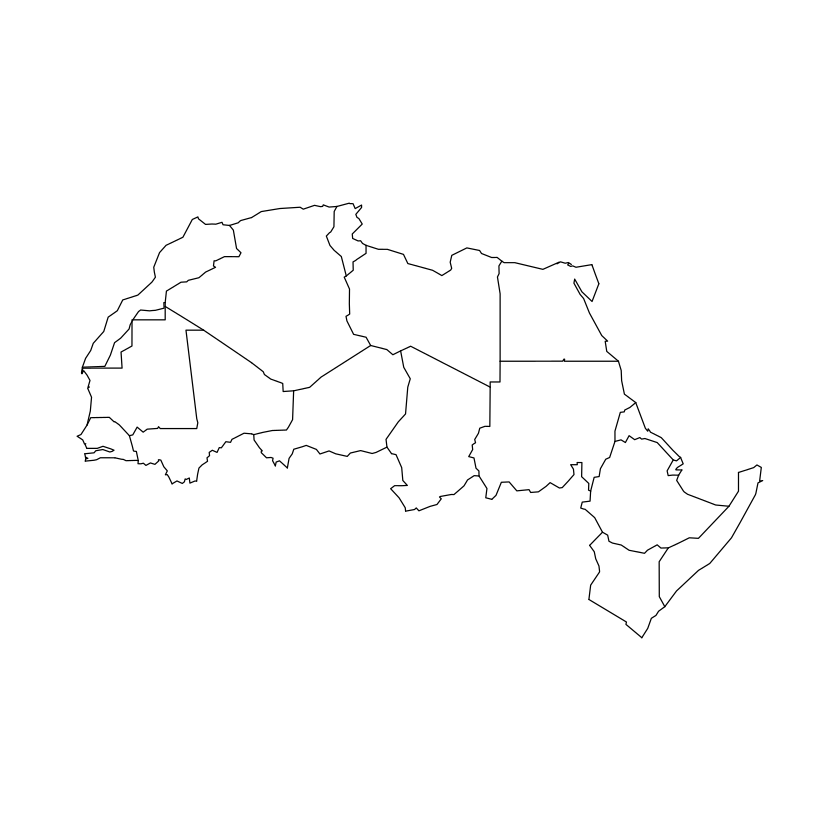

In [38]:

map(database = "world", regions =  c('Mauritania', 'Mali', 'Somalia','Egypt',"Morocco","Algeria","Sudan","Eritrea","Senegal","Libya","Western Sahara","Tunisia","Niger","Chad","Ethiopia","Djibouti","Kenya"),exact=TRUE)



# Generate Background Points
Randomly generate bakcground points.

## Randomly Generate x and y within country boundaries

In [ ]:
library(dismo)
library(tictoc)
set.seed(42)
tic()

background_points <- randomPoints(combined_raster, nrow(train_only_presence))
nrow(background_points)
plot(background_points)

toc()

## Generate random dates within date range of training data 

In [ ]:
min_date = min(as.Date(training_data_dates$observation_date,format="%Y-%m-%d"))
max_date = max(as.Date(training_data_dates$observation_date,format="%Y-%m-%d"))

background = as.data.frame(background_points)
background$date = sample(seq(min_date, max_date, by="day"), nrow(background_points), replace=TRUE)

In [ ]:
head(background_points)

In [182]:
write.csv(x=background, file="background.csv")

## Plot Different Absences
Plotting Pseudo absences.

In [12]:
plot_absence_presence <- function(whole_region,data,method,cex=3.5) {
  pseudo_absence <- data[data$presence == "0", ][c("x","y")]
  presence <- data[data$presence == "1", ][c("x","y")]

#   title <- sprintf("%s (number of pseudo_absence/background: %s number of presence: %s)",method, nrow(pseudo_absence),nrow(presence))
  title <- method
  file <- sprintf("../images/%s_sampling_size_%s.pdf", method,cex)
  pdf(file=file)
#   map(database = "world", regions =  c('Mauritania', 'Mali', 'Somalia','Egypt',"Morocco","Algeria","Sudan","Niger","Eritrea","Senegal","Libya","Western Sahara","Tunisia","Cape Verde","Chad","Ethiopia","Djibouti","Kenya"))
  map(database = "world", regions =  c('Mauritania', 'Mali', 'Somalia','Egypt',"Morocco","Algeria","Sudan","Eritrea","Senegal","Libya","Western Sahara","Tunisia","Niger","Chad","Ethiopia","Djibouti","Kenya"),exact=TRUE)
  points(pseudo_absence,col= "red", pch = ".", cex = cex)
  points(presence, col= "blue", pch = ".", cex = cex)
  dev.off()
}

In [13]:
cex=1
plot_absence_presence(combined_raster_mali_mauri,read.csv("../data/train_val_random.csv", header=TRUE),"RS",cex=cex)

png 
  2

In [14]:
cex=1
plot_absence_presence(combined_raster_mali_mauri,read.csv("../data/train_val_ep_random.csv", header=TRUE),"RSEP",cex=cex)

png 
  2

Plot background data

In [15]:
cex=1
# Read already generated background data
background <- read.csv("../data/background.csv", header=TRUE)

background[,"presence"] = 0

train <- read.csv("../data/train_val_random.csv", header=TRUE)

# Presense only train data
train_presence <- train[train$presence == "1", ]

# combine presence and background
train <- rbind(train_presence[c("x","y","presence")], background[c("x","y","presence")]) 
plot_absence_presence(combined_raster_mali_mauri,train,"BD",cex=cex)

png 
  2

Plot all data together

In [16]:
par(mfrow=c(2,2))
cex=2
plot_absence_presence(combined_raster_mali_mauri,read.csv("../data/train_val_random.csv", header=TRUE),"RS",cex=cex)
plot_absence_presence(combined_raster_mali_mauri,read.csv("../data/train_val_ep_random.csv", header=TRUE),"RSEP",cex=cex)
# plot_absence_presence(combined_raster_mali_mauri,read.csv("../data/train_val_ep_kmeans.csv", header=TRUE),"RSEP-KM",cex=cex)


# Read already generated background data
background <- read.csv("../data/background.csv", header=TRUE)

background[,"presence"] = 0

train <- read.csv("../data/train_val_random.csv", header=TRUE)

# Presense only train data
train_presence <- train[train$presence == "1", ]

# combine presence and background
train <- rbind(train_presence[c("x","y","presence")], background[c("x","y","presence")]) 
plot_absence_presence(combined_raster_mali_mauri,train,"BD",cex=cex)

png 
  2

png 
  2

png 
  2